This project is a utilization of a Siamese Neural Network for One-shot Image Recognition utilizing knowledge taken from a research paper. https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf. In this project I will create this neural network and utilize the Faces int he wild dataset to create a facial recognition Classifier.

# Dowload and Import Libraries and Dependencies

In [1]:
#using NVIDIA GeForce3 GTX 1070 
%pip install tensorflow tensorflow-gpu==2.10.1 opencv-python matplotlib

  Using cached tensorflow_gpu-2.10.1-cp310-cp310-win_amd64.whl (455.9 MB)
     ---------------------------------------- 38.2/38.2 MB 2.7 MB/s eta 0:00:00
  Using cached matplotlib-3.6.2-cp310-cp310-win_amd64.whl (7.2 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached kiwisolver-1.4.4-cp310-cp310-win_amd64.whl (55 kB)
  Using cached contourpy-1.0.6-cp310-cp310-win_amd64.whl (163 kB)
  Using cached Pillow-9.3.0-cp310-cp310-win_amd64.whl (2.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
#Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [75]:
#Import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf

In [6]:
#Avoid Out of Memory (OOM) errors by regulatiing GPU consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
len(gpus)

1

In [7]:
#Setup folder Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

 # Collect Positives and Anchors

 manual download from http://vis-www.cs.umass.edu/lfw/

In [1]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [5]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [8]:
# Import uuid library to generate unique image names
import uuid
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\e61fd68d-8a39-11ed-8448-34e12d3626ca.jpg'

In [9]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

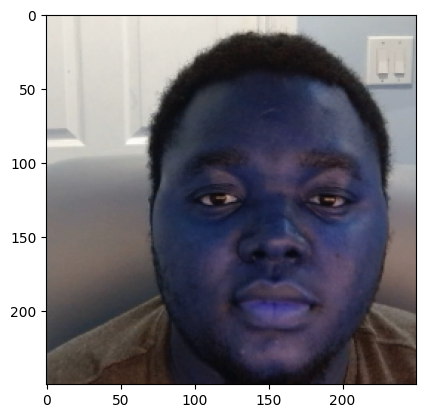

In [18]:
plt.imshow(frame)

# Load and Preprocess Images

In [19]:
# Get files in directory
#These are only the paths
anchor = tf.data.Dataset.list_files(ANC_PATH+ '\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+ '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+ '\*.jpg').take(300)

In [20]:
def preprocess(file_path):

    #Read in image from file path
    byte_img = tf.io.read_file(file_path) 
    #Load in the image
    img = tf.io.decode_jpeg(byte_img)

    #Preprocessing- resize image to be 100x100x3
    img = tf.image.resize(img, (100,100))

    #Scale image to be between 0 and 1
    img = img/255.0
    return img

In [21]:
#Classification that concatenates postives and anchor as 1, while negative and anchor as 0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [22]:
# Build Train and Test partition
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

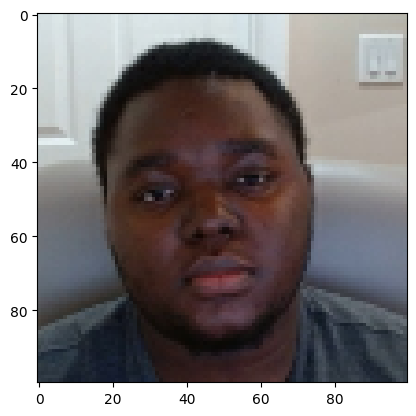

In [34]:
#Example demonstration
samples = data.as_numpy_iterator()
example = samples.next()
example
res = preprocess_twin(*example)
plt.imshow(res[1])

In [35]:
# DataLoader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [36]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [37]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Engineering

In [58]:
%%html
<img src="snn.jpg", width =1599, height= 573>

In [67]:
#Contruct embedding layer

def make_embedding():
     inp = Input(shape=(100,100,3))

     #first block
     c1 = Conv2D(64, (10,10), activation ='relu')(inp)
     m1 = MaxPooling2D(64, (2,2), padding = 'same')(c1)

     #second block
     c2 = Conv2D(128, (7,7), activation ='relu')(m1)
     m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)

     #third block
     c3 = Conv2D(128, (4,4), activation ='relu')(m2)
     m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)

     #Final
     c4 = Conv2D(256, (4,4), activation ='relu')(m3)
     f1 = Flatten()(c4)
     d1 = Dense(4096, activation='sigmoid')(f1)

     return Model(inputs=[inp], outputs=[d1], name='embedding')

In [68]:
embedding = make_embedding()

In [69]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_33 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 17, 17, 128)       26

In [63]:
# Siamese L1 Distance Class
class L1Dist(Layer): 
    def __init__(self, **kwargs):
        super().__init__()
    
    #Distance between input and anchor(similariy calculation)
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [64]:
l1 = L1Dist()

In [70]:
#Create Siamese Model
def make_siamese_model():

    #Anchor image input
    input_image = Input(name='input_img', shape=(100,100,3))

    #Validation image in network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    #Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [71]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

In [73]:
#Setup Loss and Optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [74]:
#Save our training in the event somethings goes wrong
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [76]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [77]:
#training Loop
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [78]:
#Train Model
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 38s 472ms/step
0.35178676 0.21890548 1.0

 Epoch 2/50
27/27 [==============================] - 12s 443ms/step
2.5004641e-05 0.9166667 0.9946808

 Epoch 3/50
27/27 [==============================] - 12s 436ms/step
0.20420474 0.9953488 1.0

 Epoch 4/50
27/27 [==============================] - 12s 448ms/step
0.23852955 0.74418604 0.99378884

 Epoch 5/50
27/27 [==============================] - 12s 446ms/step
0.30281848 0.30769232 1.0

 Epoch 6/50
27/27 [==============================] - 12s 448ms/step
0.18966517 0.9158416 0.99462366

 Epoch 7/50
27/27 [==============================] - 12s 450ms/step
0.5572536 0.90654206 0.97979796

 Epoch 8/50
27/27 [==============================] - 12s 449ms/step
0.17531137 0.9142857 0.9948186

 Epoch 9/50
27/27 [==============================] - 1

# Model Evaluation

In [100]:
#Test Data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 22ms/step


In [104]:
#Post processing results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]

In [105]:
y_true

array([0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.],
      dtype=float32)

In [106]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()


1.0

In [107]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 22ms/step
1.0 1.0


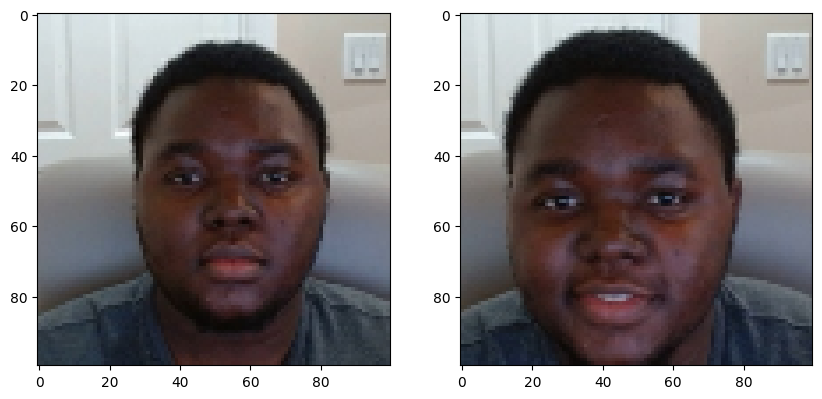

In [113]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

# Save Model

In [114]:
siamese_model.save('siamesemodel.h5')

# Real Time Test

In [115]:
 def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [116]:
#OpenCV
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 19ms/step
False
1/1 [==============================] - 0s 20ms/step
False
1/1 [==============================] - 0s 20ms/step
False
1/1 [==============================] - 0s 20ms/step
False
1/1 [==============================] - 0s 20ms/step
False
1/1 [==============================] - 0s 20ms/step
False
1/1 [==============================] - 0s 21ms/step
True
1/1 [==============================] - 0s 20ms/step
True
1/1 [==============================] - 0s 20ms/step
True
1/1 [==============================] - 0s 23ms/step
True
